# Group Details

## Group Name:

### Student 1:

### Student 2:

### Student 3:

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:

def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [3]:

"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_array('data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')


shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [4]:

example = load_array('data/task 1/train/trajectory_1.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')


shape of initial state (model input): (5, 5)
shape of terminal state (to be predicted by model): (5, 2)


In [5]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time. 
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')


shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-1.11611543  3.21149953         nan         nan]
 [-0.2865083   4.30801877         nan         nan]
 [ 1.07701594 -8.12529269         nan         nan]
 [-0.92053478  3.13709551         nan         nan]
 [-3.96308297 -4.27733589         nan         nan]
 [ 2.33945401 -8.67733599         nan         nan]
 [-4.83949085  3.67854952         nan         nan]
 [ 0.31080159 -9.74720071         nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


In [7]:
import os
import numpy as np

def pad_array(data):
    # Pad the array with zeros if necessary to have 9 rows
    padded_input_data  = np.pad(data[0], ((0, 9 - data[0].shape[0]), (0, 0)), mode='constant')
    padded_target_data = np.pad(data[1], ((0, 9 - data[1].shape[0]), (0, 0)), mode='constant') 
    return padded_input_data, padded_target_data

def create_mask(data,padded_input_data):
    # Create a boolean mask array indicating the padded rows
    mask = np.ones_like(padded_input_data, dtype=bool)
    mask[data[0].shape[0]:] = False
    return mask

def pair_values(data):
    # Pair up the values of the same columns from every row with every other row
    num_rows, num_cols = data.shape
    padded_input_data = np.zeros((num_rows, num_rows, num_cols, 2))

    for i in range(num_rows):
        pair_idx = 0
        for j in range(num_rows):
            
            padded_input_data[i, pair_idx, :, 0] = data[i]
            padded_input_data[i, pair_idx, :, 1] = data[j]
            pair_idx += 1

    return padded_input_data

def get_euclidean_distance(x):
    euclidean_distances = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        source_x, source_y= x[i][1], x[i][2]
        #euclidean_distance=[]
        for j in range(len(x)):
            target_x, target_y= x[j][1], x[j][2]
            euclidean_distances[i][j]=np.sqrt((source_x-target_x)**2+(source_y-target_y)**2)
            #euclidean_distance.append(np.sqrt((source_x-target_x)**2+(source_y-target_y)**2))
        #euclidean_distances.append(euclidean_distance)

    return euclidean_distances #list of lists

def target_difference(target_x, source_x):
    # target x and source x are of shape (9, 2)
    #Subtract the x and y coordinates of the target from the source
    return target_x - source_x


def process_file(file_path):
    # Main function to process a single file
    data = load_array(file_path, 'task 1')
    padded_input_data, padded_target_data = pad_array(data)
    mask = create_mask(data,padded_input_data)
    input_data = pair_values(padded_input_data)
    euclidean_distance = get_euclidean_distance(padded_input_data)
    target_data= target_difference(padded_target_data, padded_input_data[:,1:3])

    return input_data, target_data, padded_input_data, mask, euclidean_distance


In [8]:

class CustomDataset_2(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.file_list = os.listdir(folder)
        
    def __len__(self):
        return len(self.file_list)
    
    def _read_file(self, file_path):
        input_data, target_data,data, mask, distances= process_file(file_path)
        return input_data, target_data,data, mask, distances
    
    def __getitem__(self, index):
        file_path = os.path.join(self.folder, self.file_list[index])
        # Read and preprocess the data from the file
        input_data, target_data,data, mask, distance = self._read_file(file_path)
        # Return the preprocessed data
        return input_data, target_data,data, mask, distance
    


In [9]:
class NPEEncoder(nn.Module):
    def __init__(self, encoder_hidden_units, pairwise_hidden_units):
        super(NPEEncoder, self).__init__()
        self.pairwise_layer = nn.Linear(10, pairwise_hidden_units, bias=False)
        self.feedforward = nn.Sequential(
            nn.Linear(pairwise_hidden_units, encoder_hidden_units, bias=False),
            nn.ReLU(),
            nn.Linear(encoder_hidden_units, encoder_hidden_units, bias=False),
            nn.ReLU(),
            nn.Linear(encoder_hidden_units, encoder_hidden_units, bias=False),
            nn.ReLU(),
            nn.Linear(encoder_hidden_units, encoder_hidden_units, bias=False),
            nn.ReLU()
        )
    
    def forward(self, x):
        x= x.to(torch.float32)
        x = self.pairwise_layer(x)
        x = self.feedforward(x)
        return x

class NPEDecoder(nn.Module):
    def __init__(self, encoder_hidden_units):
        super(NPEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoder_hidden_units +5 , encoder_hidden_units),
            nn.ReLU(),
            nn.Linear(encoder_hidden_units, encoder_hidden_units),
            nn.ReLU(),
            nn.Linear(encoder_hidden_units, encoder_hidden_units),
            nn.ReLU(),
            nn.Linear(encoder_hidden_units, encoder_hidden_units),
            nn.ReLU(),
            nn.Linear(encoder_hidden_units, 2)
        )
    
    def forward(self, x):
        x = self.decoder(x)
        return x

In [10]:
class NPEModel(nn.Module):
    def __init__(self, hidden_units, pairwise_hidden_units):
        super(NPEModel, self).__init__()
        self.encoder = NPEEncoder(hidden_units, pairwise_hidden_units)
        self.decoder = NPEDecoder(hidden_units)
        self.hidden_units = hidden_units
    
    def forward(self, x,unpaired_data, mask, distance, neighborhood_threshold=5):
        output=[]
        for batch in range(x.size(0)):
            batch_data= x[batch]
            batch_output=[]
            for body in range(batch_data.size(0)):
                if torch.all(mask[batch][body]==1):
                    focus_body= unpaired_data[batch][body]

                    #get index where the distance is greater than 0 but less than threshold
                    
                    indices = np.where((distance[batch][body] > 0) & (distance[batch][body] < neighborhood_threshold))
                    

                    # Iterate through the row chunks
                    neighbor_encodings = []
                    for index in indices[0]:
                        # Process each row
                        chunk= x[batch][body][index]
                         # Convert from 5,2 to 10
                         # The order is each row after the other
                        #chunk= torch.flatten(chunk)
                        #chunk = chunk.squeeze()
                        #transpose the chunk 
                        chunk= torch.transpose(chunk, 0, 1)
                        chunk= torch.flatten(chunk)
                        chunk = chunk.squeeze()

                        processed_row = self.encoder(chunk)
                        neighbor_encodings.append(processed_row)
                    
                    # Take the sum of the neighbor encodings
                    if neighbor_encodings:
                        neighbor_encodings = torch.sum(torch.stack(neighbor_encodings), dim=0)
                    else:
                        neighbor_encodings = torch.zeros(self.hidden_units)
                    # Concatenate the focus body encoding with the focus_body
                    decoder_input = torch.cat((neighbor_encodings, focus_body), dim=0)
                    decoder_input= decoder_input.to(torch.float32)
                    # Decode the concatenated vector
                    decoded = self.decoder(decoder_input)
                    batch_output.append(decoded)
                else:
                    batch_output.append(torch.zeros(2))
            output.append(batch_output)
            

        return output

In [11]:
data_dir = 'data/task 1/train'
dataset = CustomDataset_2(data_dir)
data_loader = DataLoader(dataset, batch_size=100, shuffle=False)
test_data_dir = 'data/task 1/test'
test_dataset = CustomDataset_2(test_data_dir)
test_data_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
device = torch.device( 'cpu')


In [12]:
# Hyperparameters
hidden_units = 100
pairwise_hidden_units =  int(hidden_units/2)
learning_rate = 0.001
learning_rate_decay = 0.99
iterations = 100
batch_size = 100
patience=5


In [13]:

# Create the model
model = NPEModel(hidden_units, pairwise_hidden_units)
#model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
best_loss= float('inf')
epochs_without_improvement=0
training_losses=[]
test_losses=[]
for iteration in range(iterations):
    model.train()
    epoch_loss=0.0
    for input_data, target_data,unpaired_data, mask, distance in data_loader:
    # Training steps
        input_data = input_data.to(torch.float32)
        unpaired_data = unpaired_data.to(torch.float32)
        mask = mask.to(torch.float32)
        distance = distance.to(torch.float32)
        target_data=target_data.to(torch.float32)
        optimizer.zero_grad()
        output = model(input_data, unpaired_data, mask, distance)
        output = torch.stack([torch.stack(lst) for lst in output], dim=0)
        
        
        loss = criterion(output, target_data)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()

    epoch_loss/=len(data_loader)
    training_losses.append(epoch_loss)

    """ # Learning rate decay
    if (iteration + 1) % 10 == 0:
        learning_rate *= learning_rate_decay
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate """
    

    model.eval()
    test_loss=0.0
    with torch.no_grad():
        for input_data, target_data,unpaired_data, mask, distance in test_data_loader:
            input_data = input_data.to(torch.float32)
            target_data = target_data.to(torch.float32)
            unpaired_data = unpaired_data.to(torch.float32)
            mask = mask.to(torch.float32)
            distance = distance.to(torch.float32)
            output = model(input_data, unpaired_data, mask, distance)
            output = torch.stack([torch.stack(lst) for lst in output], dim=0)
            test_loss += criterion(output, target_data).item()
    test_loss /= len(test_data_loader)
    test_losses.append(test_loss)

    if test_loss < best_loss:
                    best_loss = test_loss
                    epochs_without_improvement = 0
                    torch.save(model.state_dict(), 'best_model2.pth')
    """ else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print('Early stopping!')
            break """

                
        # Print loss for monitoring
        #if (iteration + 1) % 10000 == 0:
    print(f"Epoch [{iteration+1}/{iterations}], Loss: {loss.item()}, Test Loss: {test_loss}")

Epoch [1/100], Loss: 5.978240489959717, Test Loss: 4.2287116050720215
Epoch [2/100], Loss: 5.506595611572266, Test Loss: 4.54177188873291
Epoch [3/100], Loss: 5.338523864746094, Test Loss: 3.8762028217315674
Epoch [4/100], Loss: 4.862577438354492, Test Loss: 3.7986838817596436
Epoch [5/100], Loss: 4.506208419799805, Test Loss: 3.2799055576324463
Epoch [6/100], Loss: 4.448071479797363, Test Loss: 3.1696159839630127
Epoch [7/100], Loss: 4.021908760070801, Test Loss: 2.914698839187622
Epoch [8/100], Loss: 4.257379531860352, Test Loss: 3.1717865467071533
Epoch [9/100], Loss: 4.0066022872924805, Test Loss: 3.0401792526245117
Epoch [10/100], Loss: 3.9108967781066895, Test Loss: 3.005657196044922
Epoch [11/100], Loss: 3.5650298595428467, Test Loss: 2.5683274269104004
Epoch [12/100], Loss: 3.77435040473938, Test Loss: 2.9218313694000244
Epoch [13/100], Loss: 3.573540210723877, Test Loss: 2.7745893001556396
Epoch [14/100], Loss: 3.4623000621795654, Test Loss: 2.6564559936523438
Epoch [15/100], 

In [15]:
def plot_losses(train_losses, test_losses, hidden_units, neighborhood_threshold, file_name):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='red')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='blue')
    #draw a vertical line at the epoch where the best test loss was achieved
    plt.axvline(np.argmin(test_losses) + 1, color='green', linestyle='--')
    #draw a horizontal line at the best test loss
    plt.axhline(np.min(test_losses), color='green', linestyle='--')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Parameter Settings: Hidden Units = {hidden_units}, Neighborhood Threshold = {neighborhood_threshold}")
    plt.legend()
    plt.savefig(file_name)
    plt.close()

In [16]:
plot_losses(training_losses, test_losses, hidden_units, 5, '100epoch.png')

## Function to plot trajectory

In [28]:
import matplotlib.pyplot as plt

def plot_trajectories(true_trajectory, predicted_trajectory):
    # Extract x and y coordinates from the trajectories
    rmse = np.sqrt(np.mean((true_trajectory - predicted_trajectory) ** 2))
    true_x = [point[0] for point in true_trajectory]
    true_y = [point[1] for point in true_trajectory]
    predicted_x = [point[0] for point in predicted_trajectory]
    predicted_y = [point[1] for point in predicted_trajectory]

    # Create the plot
    plt.figure()
    plt.plot(true_x, true_y, label='True Trajectory')
    plt.plot(predicted_x, predicted_y, label='Predicted Trajectory')

    # Set the limits for all four quadrants
    max_value = max(
        max(max(true_x), max(predicted_x)),
        max(max(true_y), max(predicted_y))
    )
    plt.xlim(-max_value - 1, max_value + 1)
    plt.ylim(-max_value - 1, max_value + 1)

    # Set the axes to cross at the origin
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)

    # Add labels and legend
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(f'Trajectory of object:  RMSE: {rmse}') #Make sure include object number
    plt.legend()

    # Show the plot
    plt.show()

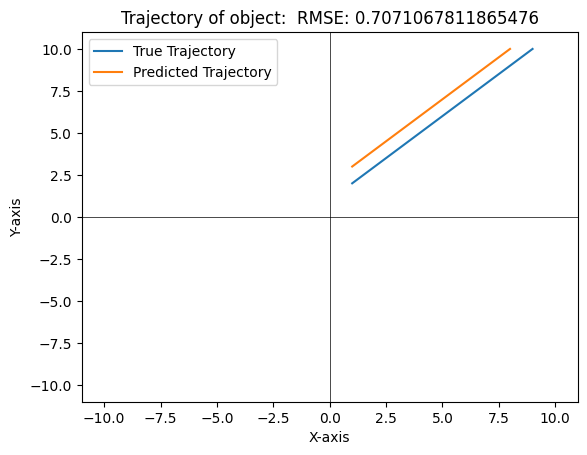

In [32]:
true_trajectory = np.array([(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)])
predicted_trajectory = np.array([(1, 3), (2, 4), (4, 6), (6, 8), (8, 10)])

plot_trajectories(true_trajectory, predicted_trajectory)


In [39]:
def generate_revolving_trajectory(radius, num_points):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    trajectory = list(zip(x, y))
    return np.array(trajectory)

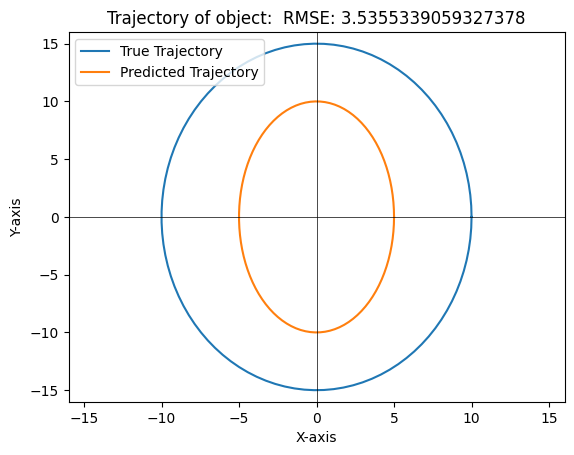

In [41]:
radius = 5
num_points = 100
revolving_trajectory = generate_revolving_trajectory(radius, num_points)
true_trajectory = generate_revolving_trajectory(radius+5, num_points)
plot_trajectories(true_trajectory, revolving_trajectory)